In [1]:
# Setup and Imports
%load_ext autoreload
%autoreload 2

import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from uncertainties import ufloat
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Add the src directory to import snowpyt_mechparams
sys.path.append('../src')
from snowpilot_utils import convert_grain_form, parse_sample_pits
from snowpyt_mechparams import density, elastic_modulus, shear_modulus, poissons_ratio


In [2]:
# Parse all snowpit files from the data folder
all_pits = parse_sample_pits('data')


Successfully parsed 50278 files
Failed to parse 0 files


In [3]:
# Calculate densities for all layers using kim_jamieson_table2 method
layer_info = []

for pit in all_pits:
    for layer in pit.snow_profile.layers:
        layer_dict = {
            'pit_id': pit.core_info.pit_id,
            'hand_hardness': layer.hardness,
            'depth_top': layer.depth_top[0] if layer.depth_top else None,  
            'thickness': layer.thickness[0] if layer.thickness else None,
        }

        # Convert grain form and calculate density
        grain_form = convert_grain_form(layer.grain_form_primary, 'kim_jamieson_table2') if layer.grain_form_primary else None
        layer_dict['kim_jamieson_table2_grain_form'] = grain_form
        layer_dict['main_grain_form'] = layer.grain_form_primary.basic_grain_class_code if layer.grain_form_primary else None
        
        # Calculate density if we have valid inputs
        if layer.hardness and grain_form:
            try:
                density_ufloat = density.calculate_density( 
                    method='kim_jamieson_table2',
                    hand_hardness=layer.hardness,
                    grain_form=grain_form
                )
                layer_dict['density_kim_jamieson_table2'] = density_ufloat.nominal_value
                layer_dict['density_kim_jamieson_table2_uncertainty'] = density_ufloat.std_dev
            except Exception:
                layer_dict['density_kim_jamieson_table2'] = None
                layer_dict['density_kim_jamieson_table2_uncertainty'] = None
        else:
            layer_dict['density_kim_jamieson_table2'] = None
            layer_dict['density_kim_jamieson_table2_uncertainty'] = None

        layer_info.append(layer_dict)

# Create dataframe
layer_df = pd.DataFrame(layer_info)


In [4]:
# Calculate elastic modulus and shear modulus using wautier method

# Function to calculate elastic modulus and shear modulus for a single row
def calculate_modulii_row(row):
    result = {'e_mod_wautier': None, 's_mod_wautier': None}
    
    # Skip if no grain form or density data
    if pd.isna(row['kim_jamieson_table2_grain_form']) or pd.isna(row['density_kim_jamieson_table2']):
        return pd.Series(result)
    
    try:
        # Create density ufloat once
        density_ufloat = ufloat(row['density_kim_jamieson_table2'], row['density_kim_jamieson_table2_uncertainty'])
        grain_form = row['kim_jamieson_table2_grain_form']
        
        # Calculate elastic modulus using wautier method
        try:
            e_mod = elastic_modulus.calculate_elastic_modulus(
                method='wautier',
                density=density_ufloat,
                grain_form=grain_form
            )
            result['e_mod_wautier'] = e_mod.nominal_value
        except Exception:
            pass
        
        # Calculate shear modulus using wautier method
        try:
            s_mod = shear_modulus.calculate_shear_modulus(
                method='wautier',
                density=density_ufloat,
                grain_form=grain_form
            )
            result['s_mod_wautier'] = s_mod.nominal_value
        except Exception:
            pass
    except Exception:
        pass
    
    return pd.Series(result)

# Apply the function to all rows at once
layer_df[['e_mod_wautier', 's_mod_wautier']] = layer_df.apply(calculate_modulii_row, axis=1)


/Users/marykateconnelly/Desktop/F25/SnowPyt-MechParams/venv/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [5]:
# Function to calculate poissons ratio for a single row using multiple methods
def calculate_poissons_ratio_row(row):
    """Calculate poissons ratio for a single row using multiple methods."""
    result = {
        'nu_kochle': np.nan,
        'nu_kochle_uncertainty': np.nan,
        'nu_srivastava': np.nan,
        'nu_srivastava_uncertainty': np.nan,
        'nu_from_elastic_and_shear_modulus': np.nan,
        'nu_from_elastic_and_shear_modulus_uncertainty': np.nan
    }
    
    # Skip if no grain form or density data
    if pd.isna(row['main_grain_form']) or pd.isna(row['density_kim_jamieson_table2']):
        return pd.Series(result)
    
    try:
        # Create density ufloat once
        density_ufloat = ufloat(row['density_kim_jamieson_table2'], row['density_kim_jamieson_table2_uncertainty'])
        grain_form = row['main_grain_form']
        
        # Calculate Poisson's ratio using Kochle method
        try:
            nu_kochle = poissons_ratio.calculate_poissons_ratio(
                method='kochle',
                grain_form=grain_form
            )
            result['nu_kochle'] = nu_kochle.nominal_value
            result['nu_kochle_uncertainty'] = nu_kochle.std_dev
        except Exception:
            pass
        
        # Calculate Poisson's ratio using Srivastava method
        try:
            nu_srivastava = poissons_ratio.calculate_poissons_ratio(
                method='srivastava',
                density=density_ufloat,
                grain_form=grain_form
            )
            result['nu_srivastava'] = nu_srivastava.nominal_value
            result['nu_srivastava_uncertainty'] = nu_srivastava.std_dev
        except Exception:
            pass
        
        # Calculate Poisson's ratio from modulii (using wautier E and G)
        # Only calculate if both e_mod_wautier and s_mod_wautier are available
        if not pd.isna(row['e_mod_wautier']) and not pd.isna(row['s_mod_wautier']):
            try:
                # Create ufloats for the moduli (assuming no uncertainty stored)
                e_mod_ufloat = ufloat(row['e_mod_wautier'], 0)
                s_mod_ufloat = ufloat(row['s_mod_wautier'], 0)
                
                nu_from_elastic_and_shear_modulus = poissons_ratio.calculate_poissons_ratio(
                    method='from_elastic_and_shear_modulus',
                    elastic_modulus=e_mod_ufloat,
                    shear_modulus=s_mod_ufloat
                )
                result['nu_from_elastic_and_shear_modulus'] = nu_from_elastic_and_shear_modulus.nominal_value
                result['nu_from_elastic_and_shear_modulus_uncertainty'] = nu_from_elastic_and_shear_modulus.std_dev
            except Exception:
                pass
        
    except Exception:
        pass
    
    return pd.Series(result)

# Apply the function to all rows at once
layer_df[['nu_kochle', 'nu_kochle_uncertainty', 'nu_srivastava', 'nu_srivastava_uncertainty', 'nu_from_elastic_and_shear_modulus', 'nu_from_elastic_and_shear_modulus_uncertainty']] = layer_df.apply(calculate_poissons_ratio_row, axis=1)


/Users/marykateconnelly/Desktop/F25/SnowPyt-MechParams/venv/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [6]:
layer_df.to_csv('poissons_ratio_comparison.csv', index=False)


In [7]:
# Create df and filter out NaN values for each method
df_kochle = layer_df[~layer_df['nu_kochle'].isna()]
df_srivastava = layer_df[~layer_df['nu_srivastava'].isna()]
df_from_elastic_and_shear_modulus = layer_df[~layer_df['nu_from_elastic_and_shear_modulus'].isna()]



In [8]:
# Print summary statistics
print("\n" + "="*80)
print("POISSON'S RATIO COMPARISON SUMMARY STATISTICS")
print("="*80)

print("\nTotal number of layers:")
print(f"  Count: {len(layer_df)}")

print("\nKÖCHLE METHOD:")
print(f"Successfully calculated: {len(df_kochle)}")
print(f"Percent of layers with successful calculation: {len(df_kochle) / len(layer_df) * 100:.2f}%")
print(f"Average uncertainty: {df_kochle['nu_kochle_uncertainty'].mean():.4f}")
print(f"Average relative uncertainty: {df_kochle['nu_kochle_uncertainty'].mean() / df_kochle['nu_kochle'].mean() * 100:.2f}%")

print("\nSRIVASTAVA METHOD:")
print(f"Successfully calculated: {len(df_srivastava)}")
print(f"Percent of layers with successful calculation: {len(df_srivastava) / len(layer_df) * 100:.2f}%")
print(f"Average uncertainty: {df_srivastava['nu_srivastava_uncertainty'].mean():.4f}")
print(f"Average relative uncertainty: {df_srivastava['nu_srivastava_uncertainty'].mean() / df_srivastava['nu_srivastava'].mean() * 100:.2f}%")

print("\nFROM WAUTIER ELASTIC AND SHEAR MODULUS METHOD:")
print(f"Successfully calculated: {len(df_from_elastic_and_shear_modulus)}")
print(f"Percent of layers with successful calculation: {len(df_from_elastic_and_shear_modulus) / len(layer_df) * 100:.2f}%")
print(f"Average uncertainty: {df_from_elastic_and_shear_modulus['nu_from_elastic_and_shear_modulus_uncertainty'].mean():.4f}")
print(f"Average relative uncertainty: {df_from_elastic_and_shear_modulus['nu_from_elastic_and_shear_modulus_uncertainty'].mean() / df_from_elastic_and_shear_modulus['nu_from_elastic_and_shear_modulus'].mean() * 100:.2f}%")




POISSON'S RATIO COMPARISON SUMMARY STATISTICS

Total number of layers:
  Count: 371429

KÖCHLE METHOD:
Successfully calculated: 142163
Percent of layers with successful calculation: 38.27%
Average uncertainty: 0.0361
Average relative uncertainty: 25.22%

SRIVASTAVA METHOD:
Successfully calculated: 103557
Percent of layers with successful calculation: 27.88%
Average uncertainty: 0.0157
Average relative uncertainty: 8.84%

FROM WAUTIER ELASTIC AND SHEAR MODULUS METHOD:
Successfully calculated: 203401
Percent of layers with successful calculation: 54.76%
Average uncertainty: 0.0000
Average relative uncertainty: 0.00%


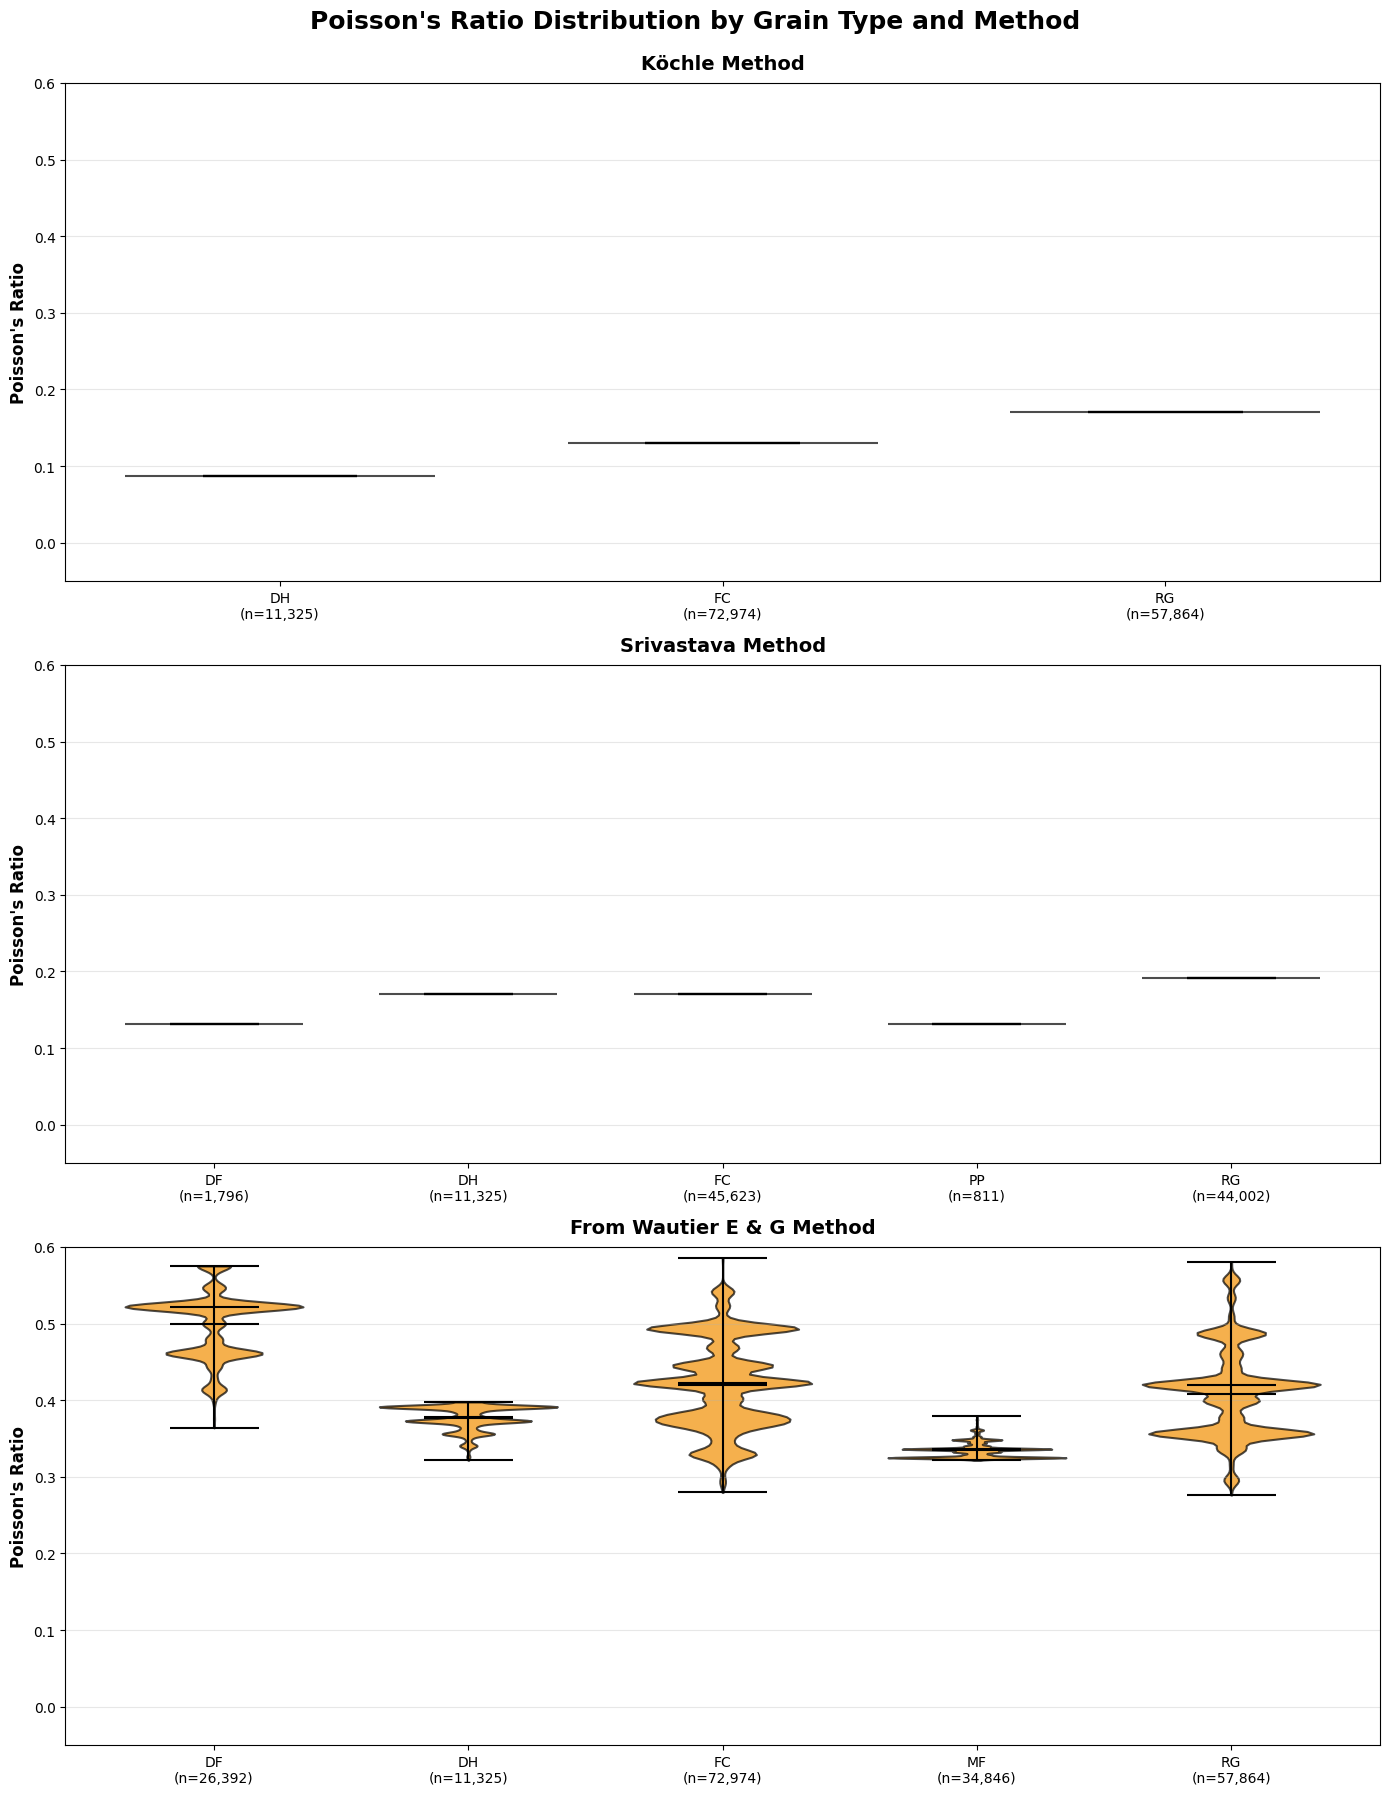

In [9]:
# Violin plots by grain type for each method
# Get all unique grain types across all methods
all_grain_types = sorted(set(
    list(df_kochle['main_grain_form'].unique()) + 
    list(df_srivastava['main_grain_form'].unique()) + 
    list(df_from_elastic_and_shear_modulus['main_grain_form'].unique())
))

# Create figure with subplots for each method
fig, axes = plt.subplots(3, 1, figsize=(14, 18))
fig.suptitle("Poisson's Ratio Distribution by Grain Type and Method", fontsize=18, fontweight='bold', y=0.995)

methods_info = [
    ('Köchle', df_kochle, 'nu_kochle', '#2E86AB', axes[0]),
    ('Srivastava', df_srivastava, 'nu_srivastava', '#A23B72', axes[1]),
    ('From Wautier E & G', df_from_elastic_and_shear_modulus, 'nu_from_elastic_and_shear_modulus', '#F18F01', axes[2])
]

for method_name, df_method, col_name, color, ax in methods_info:
    # Get grain types available for this method
    grain_types_method = sorted(df_method['main_grain_form'].unique())
    
    # Prepare data for violin plot
    data_for_violin = []
    labels = []
    positions = []
    
    for i, gt in enumerate(grain_types_method):
        data = df_method[df_method['main_grain_form'] == gt][col_name].dropna()
        if len(data) > 0:
            data_for_violin.append(data)
            labels.append(f'{gt}\n(n={len(data):,})')
            positions.append(i + 1)
    
    # Create violin plot
    if len(data_for_violin) > 0:
        parts = ax.violinplot(data_for_violin, positions=positions, showmeans=True, showmedians=True, widths=0.7)
        
        # Color the violin plots
        for pc in parts['bodies']:
            pc.set_facecolor(color)
            pc.set_alpha(0.7)
            pc.set_edgecolor('black')
            pc.set_linewidth(1.5)
        
        # Style the other elements
        for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians', 'cmeans'):
            if partname in parts:
                vp = parts[partname]
                vp.set_edgecolor('black')
                vp.set_linewidth(1.5)
    
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_ylabel("Poisson's Ratio", fontsize=12, fontweight='bold')
    ax.set_title(f'{method_name} Method', fontsize=14, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(-0.05, 0.6)

plt.tight_layout()
plt.show()


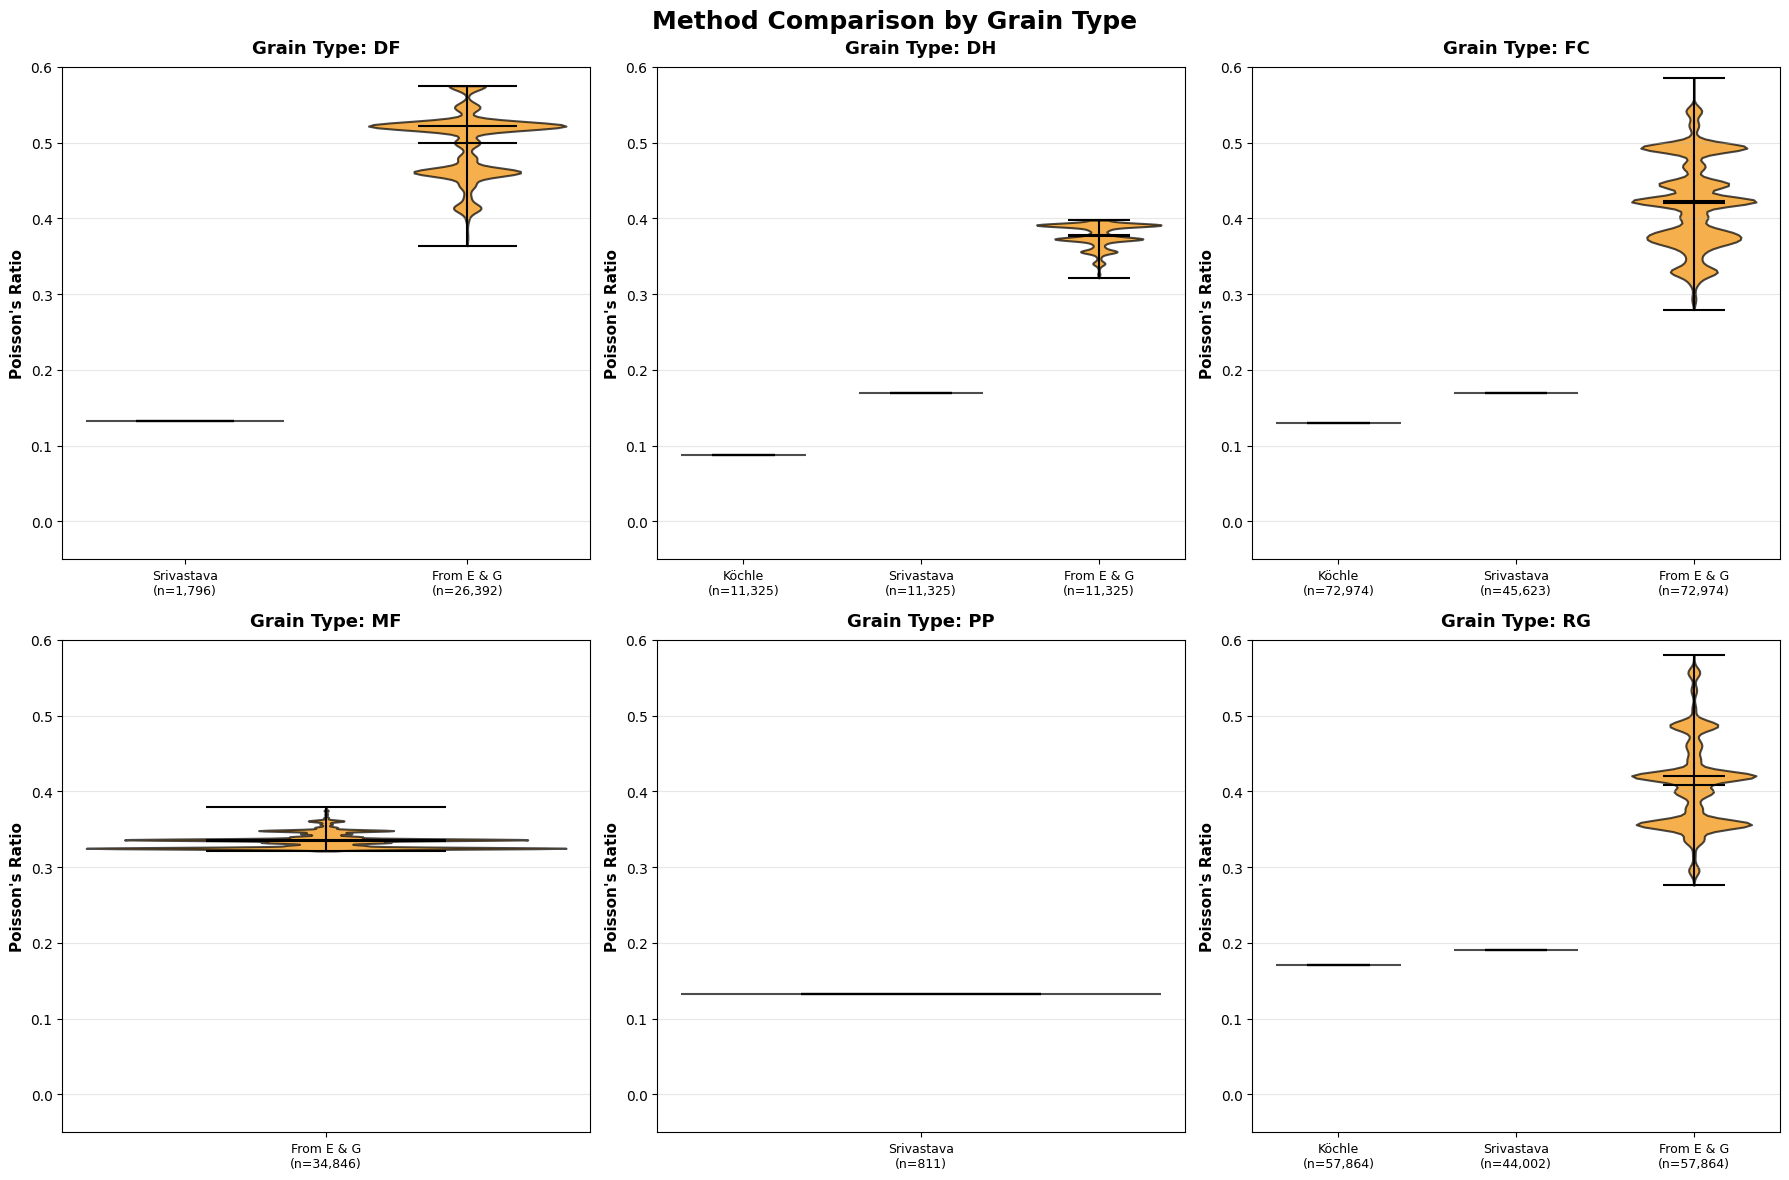

In [10]:
# Violin plots comparing all methods for each grain type
# Get grain types that have data for at least one method
all_grain_types = sorted(set(
    list(df_kochle['main_grain_form'].unique()) + 
    list(df_srivastava['main_grain_form'].unique()) + 
    list(df_from_elastic_and_shear_modulus['main_grain_form'].unique())
))

# Determine layout based on number of grain types
n_grain_types = len(all_grain_types)
if n_grain_types <= 3:
    nrows, ncols = 1, n_grain_types
    figsize = (6 * n_grain_types, 6)
elif n_grain_types <= 6:
    nrows, ncols = 2, 3
    figsize = (18, 12)
else:
    nrows, ncols = 3, 3
    figsize = (18, 18)

fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
fig.suptitle("Method Comparison by Grain Type", fontsize=18, fontweight='bold')

# Flatten axes array for easier iteration
if n_grain_types == 1:
    axes = [axes]
else:
    axes = axes.flatten() if nrows > 1 else axes

colors = ['#2E86AB', '#A23B72', '#F18F01']
method_names = ['Köchle', 'Srivastava', 'From Wautier\nE & G']

for idx, grain_type in enumerate(all_grain_types):
    ax = axes[idx]
    
    # Collect data for all methods for this grain type
    data_for_violin = []
    labels = []
    positions = []
    colors_to_use = []
    
    pos = 1
    # Köchle
    data_k = df_kochle[df_kochle['main_grain_form'] == grain_type]['nu_kochle'].dropna()
    if len(data_k) > 0:
        data_for_violin.append(data_k)
        labels.append(f'Köchle\n(n={len(data_k):,})')
        positions.append(pos)
        colors_to_use.append('#2E86AB')
        pos += 1
    
    # Srivastava
    data_s = df_srivastava[df_srivastava['main_grain_form'] == grain_type]['nu_srivastava'].dropna()
    if len(data_s) > 0:
        data_for_violin.append(data_s)
        labels.append(f'Srivastava\n(n={len(data_s):,})')
        positions.append(pos)
        colors_to_use.append('#A23B72')
        pos += 1
    
    # From Moduli
    data_m = df_from_elastic_and_shear_modulus[df_from_elastic_and_shear_modulus['main_grain_form'] == grain_type]['nu_from_elastic_and_shear_modulus'].dropna()
    if len(data_m) > 0:
        data_for_violin.append(data_m)
        labels.append(f'From E & G\n(n={len(data_m):,})')
        positions.append(pos)
        colors_to_use.append('#F18F01')
        pos += 1
    
    # Create violin plot if we have data
    if len(data_for_violin) > 0:
        parts = ax.violinplot(data_for_violin, positions=positions, showmeans=True, showmedians=True, widths=0.7)
        
        # Color each violin plot individually
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(colors_to_use[i])
            pc.set_alpha(0.7)
            pc.set_edgecolor('black')
            pc.set_linewidth(1.5)
        
        # Style the other elements
        for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians', 'cmeans'):
            if partname in parts:
                vp = parts[partname]
                vp.set_edgecolor('black')
                vp.set_linewidth(1.5)
        
        ax.set_xticks(positions)
        ax.set_xticklabels(labels, fontsize=9)
        ax.set_ylabel("Poisson's Ratio", fontsize=11, fontweight='bold')
        ax.set_title(f'Grain Type: {grain_type}', fontsize=13, fontweight='bold', pad=10)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(-0.05, 0.6)
    else:
        ax.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f'Grain Type: {grain_type}', fontsize=13, fontweight='bold', pad=10)

# Hide any unused subplots
for idx in range(n_grain_types, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()
